In [269]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tabulate
from  matplotlib.ticker import FuncFormatter

sns.set_style("whitegrid")
pd.set_option("styler.format.decimal", ",")
pd.set_option("styler.format.precision", 2)
pd.set_option("styler.format.na_rep", "–")
pd.set_option("mode.chained_assignment", None)

def write_table(df, the_name, caption=""):
    with open(f"table-{the_name}.tex", "w") as f:
        f.write(df.style.to_latex(hrules=True, sparse_index=False, environment="longtable", position="!hbt", caption=caption, label="tbl:"+the_name))

In [270]:
df = pd.read_csv("shloka/mahabharata.csv")

In [341]:
pd.crosstab(df.type, df.parva)

parva,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
type,,,,,,,,,,,,,,,,,,
Heading,859,286,1076,239,522,253,354,160,153,44,55,1100,725,291,72,15,21,11
Prose,581,0,189,0,0,0,0,0,0,0,0,287,0,0,0,0,0,0
Verse,14345,4863,21197,3758,12433,11199,16712,8056,6940,1589,1495,26231,13403,5648,2174,554,213,399


In [272]:
df_shlokas = df[(df.type == "Verse") & (~df.text.str.contains(";"))]
df_shlokas_16 = df_shlokas[df_shlokas.lengths.apply(lambda x: len(x.replace(".", ""))) == 16]

In [273]:
df_shlokas.lengths.apply(lambda x: len(x.replace(".", ""))).value_counts()

16    141658
17       281
13         2
15         1
Name: lengths, dtype: int64

In [274]:
df_shlokas[df_shlokas.lengths.apply(lambda x: len(x.replace(".", ""))) < 16]

,parva,sub_parva,verse,sub_verse,type,text,syllables,lengths
50709,5,45,7,a,Verse,dvAdazapUgAM saritaM devarakSitam,Ad.az.ap.Ug.AM s.ar.it.aM d.ev.ar.akS.it.am,GLLGG.LLG.GLGLL
50710,5,45,7,c,Verse,madhu Izantas tadA saMcaranti ghoram,adh.u .Iz.ant.as t.ad.A s.aMc.ar.ant.i gh.or.am,LL.GGG.LG.GLGL.GL
117933,12,138,58,c,Verse,punaH punar vivardheta svalpo 'py anivAritaH,un.aH p.un.ar v.iv.ardh.et.a sv.alp.o py .an.i...,LG.LG.LGGG.GG..LLGLL


In [347]:
df_shlokas[df_shlokas.lengths.apply(lambda x: (len(x.replace(".", "")) > 16) and (x.replace(".", "")[0:2] != "LL"))][["text", "lengths"]]

,text,lengths
5684,retodhAH putra unnayati naradeva yamakSayAt,GGG.GL.GLLL.LLGL.LGLG
7167,retodhAH putra unnayati naradeva yamakSayAt,GGG.GL.GLLL.LLGL.LGLG
30590,na tena sthaviro bhavati yenAsya palitaM ziraH,L.GG.LLG.LLL.GGL.LLG.LL
30627,kiM svit suptaM na nimiSati kiM svij jAtaM na ...,G.G.GG.L.LLLL.G.G.GG.L.GLL
43126,kiM svid Adityam unnayati ke ca tasyAbhitaz carAH,G.L.GGL.GLLL.G.L.GGLG.LG
43132,kena svic chrotriyo bhavati kena svid vindate ...,GG.G.GLG.LLL.GG.G.GLG.LL
43133,kena dvitIyavAn bhavati rAjan kena ca buddhimAn,GG.LGLG.LLL.GG.GL.L.GLG
43135,zrutena zrotriyo bhavati tapasA vindate mahat,LGG.GLG.LLL.LLG.GLG.LL
43136,dhRtyA dvitIyavAn bhavati buddhimAn vRddhasevayA,GG.LGLG.LLL.GLG.GLGLG
43174,kiM svit suptaM na nimiSati kiM svij jAtaM na ...,G.G.GG.L.LLLL.G.G.GG.L.GLL


In [275]:
def determine_type(lengths):
    semi_cadence = lengths.replace(".", "")[4:7]
    if semi_cadence == "LGG":
        return "Pathyā"
    else:
        return "Vipulā"
    
df_shlokas_16["type"] = df_shlokas_16.lengths.apply(determine_type)

In [276]:
df_shlokas_16.type.value_counts()

Pathyā    122245
Vipulā     19413
Name: type, dtype: int64

In [277]:
df_shlokas_16["opening"] = df_shlokas_16.lengths.apply(lambda ls: ls.replace(".", "")[0:4])
df_shlokas_16["semi_cadence"] = df_shlokas_16.lengths.apply(lambda ls: ls.replace(".", "")[4:7])
df_shlokas_16["reopening"] = df_shlokas_16.lengths.apply(lambda ls: ls.replace(".", "")[8:12])
df_shlokas_16["cadence"] = df_shlokas_16.lengths.apply(lambda ls: ls.replace(".", "")[12:15])

In [278]:
pd.crosstab(df_shlokas_16.semi_cadence, df_shlokas_16.opening)

opening,GGGG,GGGL,GGLG,GGLL,GLGG,GLGL,GLLG,GLLL,LGGG,LGGL,LGLG,LGLL,LLGG,LLGL,LLLG,LLLL
semi_cadence,,,,,,,,,,,,,,,,
GGG,30,3,2487,6,23,8,1,0,16,3,2918,2,8,7,1,0
GGL,1,0,4,0,1,0,0,0,0,1,2,0,1,1,0,0
GLG,328,1,516,0,201,0,2,0,219,0,588,0,36,1,1,0
GLL,139,4,1979,1,92,0,1,0,108,0,2128,0,24,2,1,0
LGG,15180,9321,6418,8787,19062,11664,5,6,12438,8336,6771,7312,11310,5631,2,2
LGL,4,1,2,1,0,0,0,0,1,0,98,1,2,0,0,0
LLG,18,1,6,1,8,1,0,0,6,2,5,3,5,0,0,0
LLL,1539,3,814,0,1989,0,0,0,1271,0,844,0,891,0,0,0


In [279]:
pd.crosstab(df_shlokas_16.semi_cadence, df_shlokas_16.reopening)

reopening,GGGG,GGGL,GGLG,GGLL,GLGG,GLGL,GLLG,GLLL,LGGG,LGGL,LGLG,LGLL,LLGG,LLGL,LLLG,LLLL
semi_cadence,,,,,,,,,,,,,,,,
GGG,790,618,1,442,934,545,0,0,667,458,1,289,495,273,0,0
GGL,3,3,0,1,0,0,0,0,1,0,0,1,1,1,0,0
GLG,317,193,1,138,318,175,0,0,228,145,0,112,173,93,0,0
GLL,703,429,1,372,765,442,0,0,477,400,0,247,423,220,0,0
LGG,17178,12469,12,10356,20674,12777,1,5,13469,9781,22,6961,12174,6363,2,1
LGL,5,1,0,1,2,0,0,0,5,16,78,0,2,0,0,0
LLG,14,2,0,4,10,0,0,0,13,2,0,5,5,1,0,0
LLL,1103,749,0,632,1261,752,0,0,824,562,0,432,676,360,0,0


In [280]:
pd.crosstab(df_shlokas_16.opening, df_shlokas_16.reopening, normalize=False)

reopening,GGGG,GGGL,GGLG,GGLL,GLGG,GLGL,GLLG,GLLL,LGGG,LGGL,LGLG,LGLL,LLGG,LLGL,LLLG,LLLL
opening,,,,,,,,,,,,,,,,
GGGG,2740,1774,1,1455,2868,1700,0,2,2030,1303,1,915,1615,834,1,0
GGGL,1381,962,0,838,1543,952,0,1,1102,737,2,526,858,432,0,0
GGLG,1782,1279,4,946,2041,1211,0,0,1391,980,2,658,1317,614,1,0
GGLL,1142,870,1,794,1531,936,0,0,954,724,3,488,886,467,0,0
GLGG,3018,2227,5,1830,3673,2277,1,1,2267,1621,5,1231,2107,1113,0,0
GLGL,1585,1197,0,957,1953,1277,0,0,1239,986,1,693,1167,618,0,0
GLLG,2,0,0,0,2,0,0,0,2,2,0,1,0,0,0,0
GLLL,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0
LGGG,2075,1437,1,1156,2425,1454,0,0,1591,1063,2,747,1380,728,0,0


<AxesSubplot:xlabel='parva'>

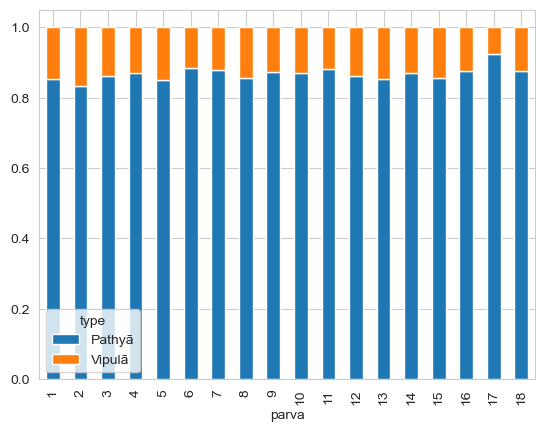

In [281]:
# sns.histplot(y="type", data=df_shlokas_16, x="parva", multiple="stack", log_scale=(False, False))
pd.crosstab(df_shlokas_16.parva, df_shlokas_16.type, normalize="index").plot.bar(stacked=True)

In [334]:
df_no_pathya = df_shlokas_16[df_shlokas_16.semi_cadence != "LGG"]
#pd.crosstab(df_no_pathya.parva, df_no_pathya.semi_cadence, normalize="index").plot.bar(stacked=True)
pd.crosstab(df_no_pathya.semi_cadence, df_no_pathya.parva).style.background_gradient(axis="index")

parva,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
semi_cadence,,,,,,,,,,,,,,,,,,
GGG,582,191,840,198,523,300,545,242,185,70,61,930,492,223,89,19,3,20
GGL,2,1,1,0,3,1,0,0,0,1,0,1,1,0,0,0,0,0
GLG,232,113,247,41,183,136,195,93,76,10,3,318,177,46,10,10,1,2
GLL,446,145,590,101,329,314,539,272,221,41,41,783,422,138,71,14,1,11
LGL,3,1,1,0,7,2,1,0,0,0,0,94,1,0,0,0,0,0
LLG,3,3,3,1,6,4,4,4,2,0,0,16,7,2,1,0,0,0
LLL,698,306,1060,111,586,470,688,358,361,80,71,1341,756,289,132,18,10,16


In [283]:
# Vipulās
df_shlokas_16.semi_cadence.value_counts()

LGG    122245
LLL      7351
GGG      5513
GLL      4479
GLG      1893
LGL       110
LLG        56
GGL        11
Name: semi_cadence, dtype: int64

In [284]:
# Cadence
df_shlokas_16.cadence.value_counts()

LGL    141556
GGL       101
LLL         1
Name: cadence, dtype: int64

In [285]:
df_tmp = df_shlokas_16
df_tmp["tmp_syllables"] = df_shlokas_16.lengths.apply(lambda x: list(enumerate(x.replace(".", ""), start=1)))
df_single_weight = df_tmp.explode("tmp_syllables")
df_single_weight["position"] = df_single_weight["tmp_syllables"].apply(lambda x: x[0])
df_single_weight["value"] = df_single_weight["tmp_syllables"].apply(lambda x: x[1])
del df_single_weight["tmp_syllables"]

In [286]:
pd.crosstab(df_single_weight.value, df_single_weight.position).style.background_gradient(axis="columns")

position,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
value,,,,,,,,,,,,,,,,
G,80659,90668,99942,90545,11896,127879,129707,97887,85199,81734,121540,73829,101,141657,0,54236
L,60999,50990,41716,51113,129762,13779,11951,43771,56459,59924,20118,67829,141557,1,141658,87422


In [325]:
pd.crosstab([df_single_weight.semi_cadence, df_single_weight.position], df_single_weight.value).unstack()["G"].sort_values(14, ascending=False).style.background_gradient(axis="columns")

position,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
semi_cadence,,,,,,,,,,,,,,,,
LGG,70443,74563,92942,71186,0,122245,122245,81601,73472,70248,104885,63532,92,122244,0,46673
LLL,4345,4471,5693,7348,0,0,0,6975,4497,4302,6287,3864,0,7351,0,2862
GGG,2558,5465,98,5484,5513,5513,5513,3612,3330,3266,4780,2888,4,5513,0,2123
GLL,2216,4359,369,4472,4479,0,0,4107,2712,2629,3859,2369,1,4479,0,1778
GLG,1048,1652,786,1891,1893,0,1893,1443,1142,1134,1642,1037,4,1893,0,724
LGL,8,108,8,107,0,110,0,90,9,106,31,92,0,110,0,48
LLG,35,42,41,48,0,0,56,49,30,40,47,42,0,56,0,25
GGL,6,8,5,9,11,11,0,10,7,9,9,5,0,11,0,3


In [324]:
# no effect to be seen, also tried with .reopening and .cadence
pd.crosstab([df_single_weight.opening, df_single_weight.position], df_single_weight.value).unstack()["G"].sort_values(14, ascending=False).style.background_gradient(axis="columns")

position,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
opening,,,,,,,,,,,,,,,,
GLGG,21376,0,21376,21376,317,19086,19294,14625,13032,12204,18303,11076,13,21376,0,8310
GGGG,17239,17239,17239,17239,498,15215,15556,11441,10540,10219,14864,9256,15,17239,0,6706
LGGG,0,14059,14059,14059,343,12455,12679,9610,8548,8072,12153,7474,12,14058,0,5403
LGLG,0,13354,0,13354,5636,9789,10282,9839,7864,7837,11420,7069,4,13354,0,5050
LLGG,0,0,12277,12277,69,11321,11359,8283,7416,7175,10487,6233,5,12277,0,4605
GGLG,12226,12226,0,12226,4986,8911,9427,8684,7263,7042,10615,6538,10,12226,0,4792
GLGL,11673,0,11673,0,8,11672,11673,8019,6969,6658,10022,5945,10,11673,0,4519
GGGL,9334,9334,9334,0,8,9325,9326,6421,5677,5548,7967,4886,9,9334,0,3607
GGLL,8796,8796,0,0,7,8794,8794,6208,5274,4976,7510,4517,11,8796,0,3408


In [289]:
def enumerate_sublists(lists):
    index = 1
    result = []
    for element in lists:
        result.append((index, element))
        index += len(element)
    return result

In [290]:
df_tmp = df_shlokas_16
df_tmp["tmp_words"] = df_tmp.apply(lambda row: tuple(zip(enumerate_sublists(row["lengths"].split(".")), row["text"].split(" "))), axis=1)
df_localisation = df_tmp.explode("tmp_words")
df_localisation["position"] = df_localisation["tmp_words"].apply(lambda x: x[0][0])
df_localisation["schema"] = df_localisation["tmp_words"].apply(lambda x: x[0][1])
df_localisation["word"] = df_localisation["tmp_words"].apply(lambda x: x[1])
del df_localisation["tmp_words"]

In [323]:
x = df_localisation[["word", "schema", "syllables", "text", "lengths"]]
x[x.word == "iti"]
#["schema"].value_counts()

,word,schema,syllables,text,lengths
87,iti,LG,ev.abhr.AT t.an.ay.as t.asy.a t.asm.At s.ubhr....,devabhrAT tanayas tasya tasmAt subhrAD iti smRtaH,GGG.LLG.GL.GG.GG.LG.LL
152,iti,LL,Ah.uH k.e c.in n.a t.asy.ait.e t.asy.ait.a .it...,AhuH ke cin na tasyaite tasyaita iti cApare,GG.G.G.L.GGG.GGL.LL.GLG
155,iti,LL,ucy.at.AM sv.Ag.at.am .it.i v.Ac.o zr.Uy.ant.a...,ucyatAM svAgatam iti vAco 'zrUyanta sarvazaH,GLG.GLL.LL.GG.GGL.GLL
348,iti,LL,it.i r.AjJ.AM c.at.urv.iMz.an n.Ar.ad.en.a s.u...,iti rAjJAM caturviMzan nAradena surarSiNA,LL.GG.LGGG.GLGL.LGLG
424,iti,LL,adh.It.aM bh.Ar.at.aM t.en.a k.Rtsn.aM sy.Ad ....,adhItaM bhArataM tena kRtsnaM syAd iti me matiH,LGG.GLG.GL.GG.G.LL.G.LL
...,...,...,...,...,...
158158,iti,LL,arN.asy.a kr.iy.at.AM t.oy.am .it.i t.apy.Am.i...,karNasya kriyatAM toyam iti tapyAmi tena vai,GGG.LLG.GL.LL.GGL.GL.G
158222,iti,LG,ah.o k.Rcchr.am .it.i pr.Ah.a t.asth.au s.a c....,aho kRcchram iti prAha tasthau sa ca yudhiSThiraH,LG.GL.LG.GL.GG.L.L.LGLL
158228,iti,LG,arN.o h.aM bh.Im.as.en.o h.am .arj.un.o h.am ....,karNo 'haM bhImaseno 'ham arjuno 'ham iti prabho,GG.G.GLGG.L.GLG.L.LG.LG
158371,iti,LL,Ury.ap.utr.o gr.aj.aH zr.eSTh.o r.Adh.ey.a .it...,sUryaputro 'grajaH zreSTho rAdheya iti vizrutaH,GLGG.LG.GG.GGL.LL.GLL


In [317]:
# How many metrical shapes do words appear in?
df_localisation.groupby("word")["schema"].nunique().value_counts()

1    153933
2      4237
Name: schema, dtype: int64

In [293]:
pd.crosstab(df_localisation.semi_cadence, df_localisation.position).sort_values(1, ascending=False).style.background_gradient(axis="columns")

position,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
semi_cadence,,,,,,,,,,,,,,,,
LGG,122245,15768,43000,49071,45508,26313,54315,14202,122156,9746,39677,47120,47653,27332,31110,7260
LLL,7351,819,2835,1582,3169,3621,834,104,7342,542,2382,2689,2772,1569,1740,424
GGG,5513,844,1968,1614,306,5427,503,851,5516,448,1850,2111,2165,1251,1476,321
GLL,4479,748,1388,916,1321,2708,709,90,4480,323,1473,1628,1777,930,1115,204
GLG,1893,159,650,63,1831,47,152,252,1892,129,566,756,749,428,532,92
LGL,110,33,41,31,27,54,14,5,109,11,24,42,29,26,42,6
LLG,56,4,16,4,51,4,8,4,56,2,23,18,26,16,16,4
GGL,11,1,3,5,5,9,2,0,11,2,2,4,5,2,2,2


In [308]:
pd.crosstab(df_localisation.schema, df_localisation.position).sort_values(1, ascending=False).head(28).style.background_gradient(axis="columns")

position,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
schema,,,,,,,,,,,,,,,,
GG,18954,3404,11181,2097,1,4009,41870,0,20724,2575,11708,10,0,0,0,0
LG,15024,1877,2023,6,16203,3,1388,0,12577,1336,8,1,9434,0,14383,0
G,10459,2485,5612,3748,565,4964,1887,7127,7046,2031,4938,3737,25,3027,0,2165
GLG,8916,644,2,9143,228,39,0,0,11669,3,6,5388,0,10485,0,0
L,7562,2684,4440,4200,8918,551,56,8376,4081,1386,1737,4574,6766,0,1137,6148
GL,7006,1613,2611,5219,304,2,10793,0,5603,657,4516,5440,0,1623,0,0
GGG,6887,430,21,1,2,13434,0,1,8787,394,32,0,0,0,0,0
LGG,6556,831,1912,3,3035,22,0,1,8250,523,0,0,0,0,0,0
GLGG,5827,823,0,2420,1174,0,3,1,8734,0,0,0,0,0,0,0


<AxesSubplot:>

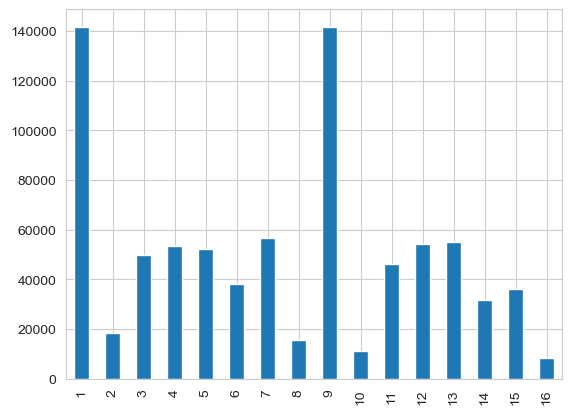

In [295]:
df_localisation["position"].value_counts().sort_index().plot.bar()

In [340]:
df_shlokas_16[(df_shlokas_16.reopening.str[1:3] == "LL") | (df_shlokas_16.opening.str[1:3] == "LL")][["parva", "sub_parva", "verse", "sub_verse", "text", "lengths"]]

,parva,sub_parva,verse,sub_verse,text,lengths
763,1,2,158,c,adhyAyAnAM zataM proktaM saptadaza tathApare,GGGG.LG.GG.GLLL.LGLG
935,1,2,234,a,etad akhilam AkhyAtaM bhArataM parvasaMgrahAt,GL.LLL.GGG.GLG.GLGLG
3225,1,39,29,c,yad gRhItaM phalaM rAjJA tatra kRmir abhUd aNuH,G.LGG.LG.GG.GL.LL.LG.LL
8125,1,99,41,a,katham arAjakaM rASTraM zakyaM dhArayituM prabho,LL.LGLG.GG.GG.GLLG.LG
11782,1,158,14,a,na kuNapAH zRGgiNo vA na devA na ca mAnuSAH,L.LLG.GLG.G.L.GG.L.L.GLG
16497,2,10,4,a,razmivatI bhAsvarA ca divyagandhA manoramA,GLLG.GLG.L.GLGG.LGLG
17240,2,19,10,a,aparihAryA meghAnAM mAgadheyaM maNeH kRte,LLLGG.GGG.GLGG.LG.LG
38051,3,222,36,c,nApi parivade zvazrUM sarvadA pariyantritA,GL.LLLG.GG.GLG.LLGLG
38057,3,222,39,c,nApi parivade cAhaM tAM pRthAM pRthivIsamAm,GL.LLLG.GG.G.LG.LLGLG
45056,4,29,26,c,vayam api nigRhNImo dvidhA kRtvA varUthinIm,LL.LL.LGGG.LG.GG.LGLG


In [310]:
df_shlokas_16[(df_shlokas_16.reopening.str[1:4] == "GLG")]["parva"].value_counts()

12    86
7      9
3      4
13     4
5      3
6      3
9      2
14     2
2      1
4      1
8      1
Name: parva, dtype: int64